In [49]:
%cd /Users/sumishunsuke/Desktop/RNA/raptcouple_test

/Users/sumishunsuke/Desktop/RNA/raptcouple_test


# Fig. 2c
comparison of sequence annotatioins

In [50]:
import sys
sys.path.append("./")
import glob
from src.plmc import read_params

data_dir = "example/Jolma2020/outputs"
model_params = glob.glob(data_dir + "/*.model_params")
model_params[:10]

['example/Jolma2020/outputs/128_RBMY1E_TGGTGG40NTAA_EMO_4-971-24-66.20-20.model_params',
 'example/Jolma2020/outputs/70_RNPC3_TTAACA40NTGT_AAH_3-92-60-269.95-2.model_params',
 'example/Jolma2020/outputs/115_RBFOX1-construct2_TTGCGA40NTACG_AAG_4-992-1-6.10-160746.model_params',
 'example/Jolma2020/outputs/52_RBM14_TTAGCA40NGGT_AAG_4-90-36-174.14-1.model_params',
 'example/Jolma2020/outputs/115_RBFOX1_TGTCTT40NTTC_AAG_4-969-1-6.43-153461.model_params',
 'example/Jolma2020/outputs/27_IGF2BP1-construct4_TTAGGT40NTAA_AAG_4-994-11-58.98-105.model_params',
 'example/Jolma2020/outputs/103_DAZ1-construct2_TGGCCT40NATTT_AAG_4-979-5-27.58-42.model_params',
 'example/Jolma2020/outputs/24_HNRNPCL1_TAGCCA40NTAT_AAG_4-933-7-48.86-90.model_params',
 'example/Jolma2020/outputs/23_HNRNPC_TTCTTG40NCTTT_AAH_3-64-6-34.01-109.model_params',
 'example/Jolma2020/outputs/66_RBPMS2_TCTAAA40NCGC_EMN_4-9564-13-12.81-840.model_params']

In [51]:
import numpy as np

def cosine(p, q):
    """
    p: ( n_category, L)
    q: (n_category, L)
    """
    return (p * q).sum(axis=0) / (np.linalg.norm(p, axis=0) * np.linalg.norm(q, axis=0))


def calc_max_cosine_sim(pwm_jolma, pos_field, max_padding=2):
    x,y = [], []
    # reduce padding lengh  so that maxpadding < len(pwm_jolma.columns)/2
    max_padding = min(max_padding, len(pwm_jolma.columns)//2)
    for i in range(-max_padding, len(pos_field.columns)-len(pwm_jolma.columns)+max_padding+1):
        # print(i)
        if i < 0:
            cos = cosine(
                pos_field.values[:, :len(pwm_jolma.columns)+i],
                pwm_jolma.values[:, -i:]
            ).mean()
        elif i > len(pos_field.columns)-len(pwm_jolma.columns):
            cut_leng = i - (len(pos_field.columns)-len(pwm_jolma.columns))
            cos = cosine(
                pos_field.values[:,i:],
                pwm_jolma.values[:, -len(pwm_jolma.columns)+cut_leng:]
            ).mean()
        else: # normal
            cos = cosine(
                pos_field.values[:, i:i+len(pwm_jolma.columns)],
                pwm_jolma.values,
                ).mean()
        x.append(i)
        y.append(cos)

    max_sim = max(y)
    return x, y, max_sim

In [52]:
from src.helper_jolma import load_pwms

dict_gene2motif_jolma = load_pwms("example/Jolma2020/data/Supplemental_Tables_S1-S8.xlsx")
dict_gene2motif_jolma["CARHSP1_TGCAGT40NAAG_AAG_UUGCCUUGUCCCGAU_2_3_monomeric_Primary_Experiment_1"]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
A,0.114736,0.098403,0.039801,0.000000,0.000000,0.001223,0.0,0.00047,0.0,0.00000,0.000000,0.000000,0.005005,0.560771,0.107303
C,0.110075,0.085035,0.001357,0.975069,0.996718,0.165104,0.0,0.00000,0.0,0.99953,0.992997,0.930911,0.009099,0.036778,0.101341
G,0.100394,0.096918,0.951606,0.000000,0.000000,0.000408,0.0,0.99953,0.0,0.00000,0.000000,0.000000,0.964513,0.279860,0.121833
U,0.674794,0.719644,0.007237,0.024931,0.003282,0.833265,1.0,0.00000,1.0,0.00047,0.007003,0.069089,0.021383,0.122592,0.669523


In [53]:
import pandas as pd 
from src.helper_jolma import trim_pwm_with_entropy



threshold = 1.5
x_,y_ = np.nan, np.nan
min_max_cosine = 0.7
res_compares = []

# dict_gene2motif_jolma.keys でfor を回して, match するmodel paramsをscan
# {model_params:max}

gene2score = {}

for tf_key, pwm_jolma in dict_gene2motif_jolma.items():
    pwm_jolma = trim_pwm_with_entropy(pwm_jolma.loc[list("AUGC")], threshold=threshold)
    gene, *_ = tf_key.split("_")
    model_params = glob.glob(data_dir + f"/*_{gene}_*.model_params")
    for model_param in model_params:
        model_params = read_params(model_param)
        pos_field = pd.DataFrame(model_params["fi"], columns = list(model_params["alphabet"])).T # AUGC.
        x,y, max_sim = calc_max_cosine_sim(pwm_jolma, pos_field.iloc[range(4)], max_padding = 3)
        if gene in gene2score:
            if gene2score[gene] < max_sim:
                gene2score[gene] = max_sim
        else:
            gene2score[gene] = max_sim
        if max_sim < min_max_cosine:            
            min_max_cosine = max_sim
            x_,y_ = x,y
            print(tf_key, model_param, max_sim) 
        res_compares.append([tf_key, model_param, max_sim])

gene2score["BOLL"]

CARHSP1_TGCAGT40NAAG_AAG_GCCAUGAUCAUGAU_2_3_dimeric_Secondary_Experiment_1 example/Jolma2020/outputs/2_CARHSP1_TGCAGT40NAAG_EMJ_4-798-9-94.21-71.model_params 0.5724754058236654
RBMS1_TATTCA40NTCAG_AAG_UUAUAAUCAAC_2_3_monomeric_Secondary_Experiment_1 example/Jolma2020/outputs/123_RBMS1_TGAGAG40NCGC_AAG_4-928-12-70.97-88.model_params 0.5194702468764308


0.841438087990815

mean 0.9302517829127352
std 0.08489397123332516
median 0.9654805816063899


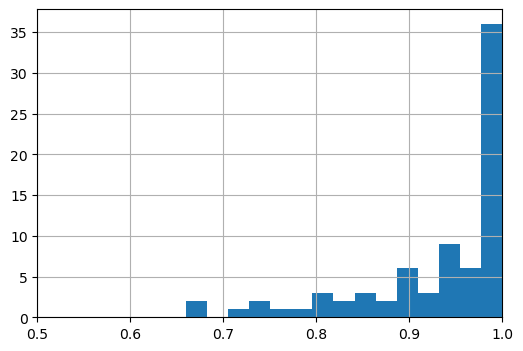

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.xlim(0.5, 1)
plt.hist(list(gene2score.values()), bins = 15)
plt.grid(0.3)
# plt.savefig("example/Jolma2020/outputs/cosine_sim_pwm.pdf", transparent=True)

print("mean", np.mean(list(gene2score.values())))
print("std", np.std(list(gene2score.values())))
print("median", np.median(list(gene2score.values())))